# Strategia Momentum sulle Commodities

Questo notebook mostra come applicare una strategia momentum top n ranking sulle commodities utilizzando i dati reali e il modulo Python sviluppato ad hoc.

## 1. Importare librerie e configurare ambiente

Importiamo le librerie principali e configuriamo le opzioni di visualizzazione di pandas.

In [4]:
# Parametri strategia momentum commodities
lookback_days = 14  # periodo di lookback per il momentum
top_n = 3          # numero massimo di commodities da selezionare
rebalance_weekday = 4  # giorno di ribilanciamento (0=lun, ..., 4=ven)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from core.commodity_momentum import generate_commodity_momentum_signals

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1200)


## 2. Caricare dati commodities da Parquet

Carichiamo i dati delle commodities dal file Parquet e visualizziamo le prime righe.

In [2]:
df = pd.read_parquet('data/commodities_extended_data.parquet')
df.head()

,GOLD_Open,GOLD_High,GOLD_Low,GOLD_Close,GOLD_Volume,GOLD_Dividends,GOLD_Stock Splits,SILVER_Open,SILVER_High,SILVER_Low,...,SUGAR_Volume,SUGAR_Dividends,SUGAR_Stock Splits,COTTON_Open,COTTON_High,COTTON_Low,COTTON_Close,COTTON_Volume,COTTON_Dividends,COTTON_Stock Splits
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,50.430000,51.099998,50.349998,51.070000,8033.0,0.0,0.0
2000-01-04 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,50.900002,50.970001,50.250000,50.730000,4709.0,0.0,0.0
2000-01-05 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,50.750000,51.840000,50.750000,51.560001,10464.0,0.0,0.0
2000-01-06 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,51.900002,52.099998,51.549999,52.080002,7247.0,0.0,0.0
2000-01-07 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,52.080002,54.049999,51.900002,53.959999,19389.0,0.0,0.0


## 3. Esplorare struttura e qualità dati

Analizziamo le colonne, i tipi di dato, la presenza di NaN, il range temporale e i simboli disponibili.

In [4]:
print('Colonne:', df.columns.tolist())
print('Tipi di dato:')
print(df.dtypes.value_counts())
print('Valori NaN per colonna:')
print(df.isna().sum().sort_values(ascending=False).head(10))
print('Range temporale:', df.index.min(), '->', df.index.max())
commodities = sorted(set([c.split('_')[0] for c in df.columns if c.endswith('_Close')]))
print('Commodities disponibili:', commodities)

Colonne: ['GOLD_Open', 'GOLD_High', 'GOLD_Low', 'GOLD_Close', 'GOLD_Volume', 'GOLD_Dividends', 'GOLD_Stock Splits', 'SILVER_Open', 'SILVER_High', 'SILVER_Low', 'SILVER_Close', 'SILVER_Volume', 'SILVER_Dividends', 'SILVER_Stock Splits', 'CRUDE_WTI_Open', 'CRUDE_WTI_High', 'CRUDE_WTI_Low', 'CRUDE_WTI_Close', 'CRUDE_WTI_Volume', 'CRUDE_WTI_Dividends', 'CRUDE_WTI_Stock Splits', 'CRUDE_BRENT_Open', 'CRUDE_BRENT_High', 'CRUDE_BRENT_Low', 'CRUDE_BRENT_Close', 'CRUDE_BRENT_Volume', 'CRUDE_BRENT_Dividends', 'CRUDE_BRENT_Stock Splits', 'NATGAS_Open', 'NATGAS_High', 'NATGAS_Low', 'NATGAS_Close', 'NATGAS_Volume', 'NATGAS_Dividends', 'NATGAS_Stock Splits', 'COPPER_Open', 'COPPER_High', 'COPPER_Low', 'COPPER_Close', 'COPPER_Volume', 'COPPER_Dividends', 'COPPER_Stock Splits', 'PLATINUM_Open', 'PLATINUM_High', 'PLATINUM_Low', 'PLATINUM_Close', 'PLATINUM_Volume', 'PLATINUM_Dividends', 'PLATINUM_Stock Splits', 'PALLADIUM_Open', 'PALLADIUM_High', 'PALLADIUM_Low', 'PALLADIUM_Close', 'PALLADIUM_Volume', 'P

## 4. Calcolare rendimenti e ranking momentum

Calcoliamo i rendimenti cumulativi su un periodo di lookback configurabile e ordiniamo le commodities per momentum.

In [5]:
close_cols = [c for c in df.columns if c.endswith('_Close')]
close_prices = df[close_cols].copy()
close_prices.columns = [c.replace('_Close', '') for c in close_cols]
# Calcolo rendimenti cumulativi per ogni commodity
cumret = close_prices / close_prices.shift(lookback_days) - 1
last_date = cumret.index[-1]
latest_cumret = cumret.loc[last_date].sort_values(ascending=False)
print('Ranking momentum ultimo giorno:')
print(latest_cumret)

Ranking momentum ultimo giorno:
GOLD           0.023425
CORN           0.021807
CRUDE_BRENT    0.014408
CRUDE_WTI      0.013981
SOYBEANS      -0.006533
PALLADIUM     -0.014528
SILVER        -0.016229
SUGAR         -0.021739
COTTON        -0.039429
WHEAT         -0.042751
PLATINUM      -0.048459
COFFEE        -0.072115
NATGAS        -0.130287
COPPER        -0.200325
Name: 2025-08-04 00:00:00-04:00, dtype: float64


## 5. Selezionare top n commodities con momentum positivo

Selezioniamo le prime n commodities con rendimento cumulativo positivo. Se nessuna soddisfa il criterio, impostiamo posizione cash.

In [6]:
positive = latest_cumret[latest_cumret > 0]
if len(positive) == 0:
    print('Nessuna commodity con momentum positivo: tutto cash')
    selected = []
else:
    selected = positive.head(top_n)
    print(f'Top {top_n} commodities con momentum positivo:')
    print(selected)

Top 3 commodities con momentum positivo:
GOLD           0.023425
CORN           0.021807
CRUDE_BRENT    0.014408
Name: 2025-08-04 00:00:00-04:00, dtype: float64


## 6. Simulare strategia momentum settimanale

Applichiamo la logica di ribilanciamento settimanale: ogni venerdì selezioniamo il portafoglio, calcoliamo i pesi e il rendimento del portafoglio nel tempo.

In [5]:
# Simulare strategia momentum settimanale con segnali aggiornati
signals = generate_commodity_momentum_signals(df, lookback_days=lookback_days, top_n=top_n, rebalance_weekday=rebalance_weekday)
close_prices = df[[c for c in df.columns if c.endswith('_Close')]]
close_prices.columns = [c.replace('_Close', '') for c in close_prices.columns]
daily_returns = close_prices.pct_change().fillna(0)
# Allineamento colonne signals e daily_returns: rimuovo '_weight' da signals
signals_aligned = signals.copy()
signals_aligned.columns = [c.replace('_weight','') for c in signals_aligned.columns]
# Calcolo rendimento portafoglio momentum
portf_ret = (signals_aligned * daily_returns).sum(axis=1)
equity = (1 + portf_ret).cumprod()
equity.name = 'Momentum Equity'
equity.head()

Date
2000-01-03 00:00:00-05:00    1.0
2000-01-04 00:00:00-05:00    1.0
2000-01-05 00:00:00-05:00    1.0
2000-01-06 00:00:00-05:00    1.0
2000-01-07 00:00:00-05:00    1.0
Name: Momentum Equity, dtype: float64

## 7. Visualizzare performance e composizione portafoglio

Visualizziamo l'equity line della strategia momentum e la composizione del portafoglio nel tempo.

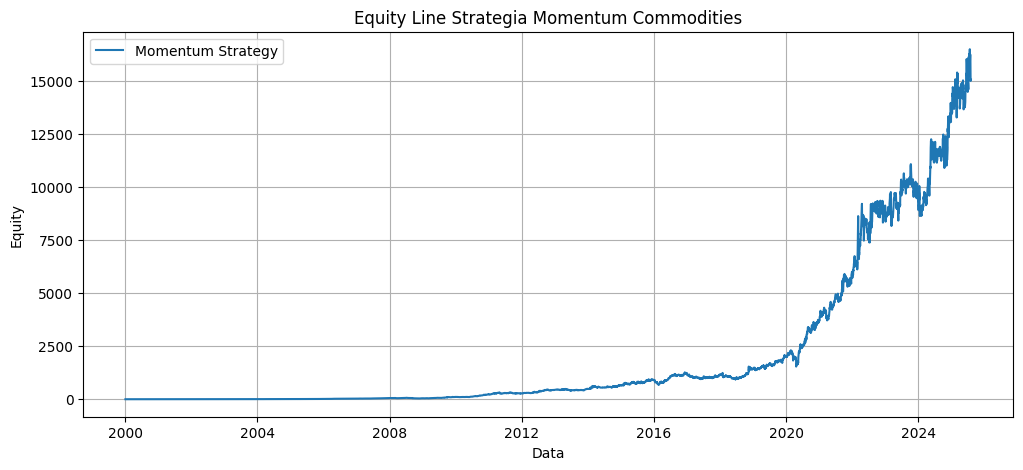

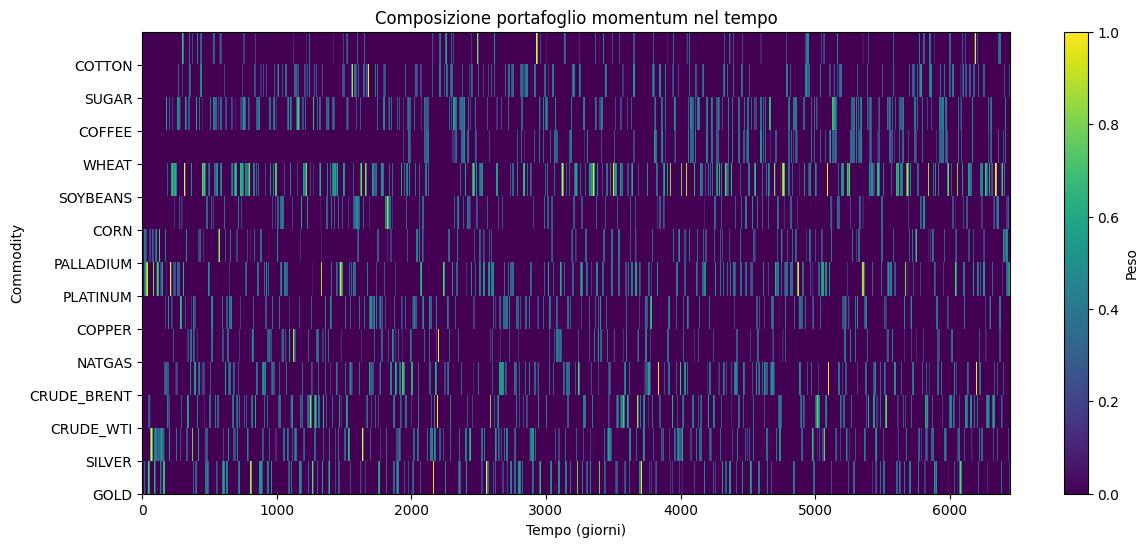

In [6]:
# Visualizzazione performance e composizione portafoglio con segnali aggiornati
plt.figure(figsize=(12,5))
plt.plot(equity, label='Momentum Strategy')
plt.title('Equity Line Strategia Momentum Commodities')
plt.xlabel('Data')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.show()

# Heatmap pesi portafoglio aggiornata
plt.figure(figsize=(14,6))
plt.imshow(signals_aligned.T, aspect='auto', interpolation='none', cmap='viridis', extent=[0, signals_aligned.shape[0], 0, signals_aligned.shape[1]])
plt.colorbar(label='Peso')
plt.yticks(np.arange(len(signals_aligned.columns)), signals_aligned.columns)
plt.title('Composizione portafoglio momentum nel tempo')
plt.xlabel('Tempo (giorni)')
plt.ylabel('Commodity')
plt.show()

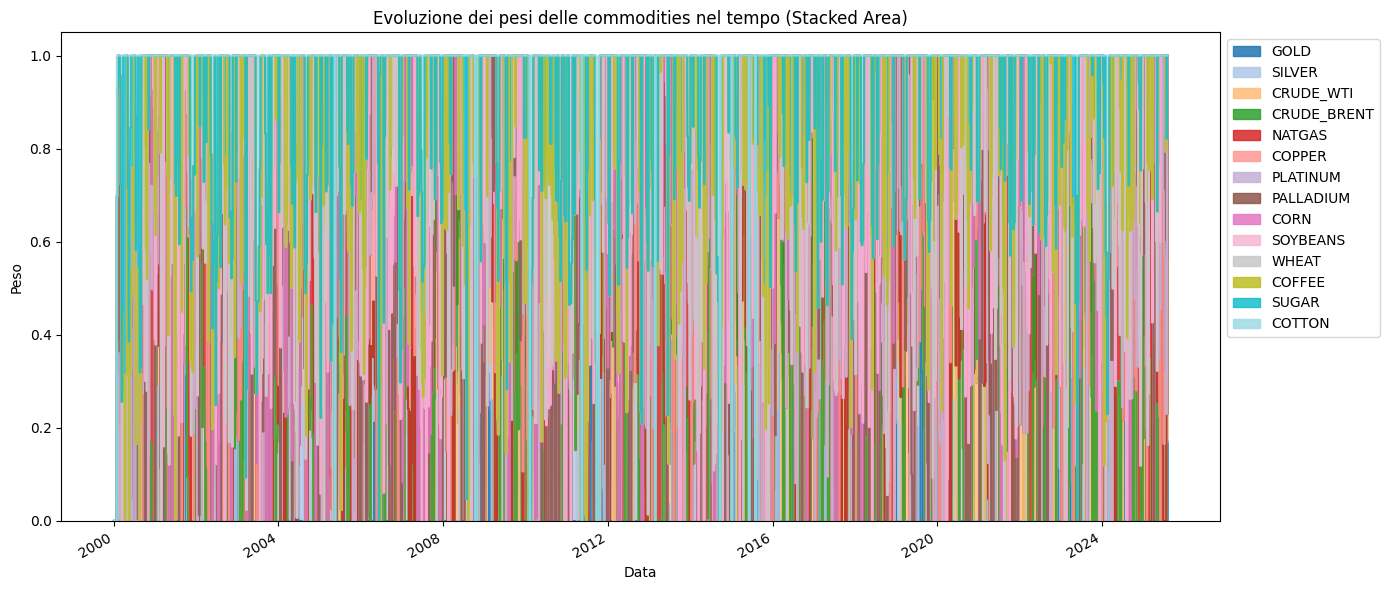

In [7]:
# Grafico ad area: evoluzione dei pesi delle commodities nel tempo (segnali aggiornati)
plt.figure(figsize=(14,6))
signals_aligned.plot.area(ax=plt.gca(), cmap='tab20', alpha=0.85)
plt.title('Evoluzione dei pesi delle commodities nel tempo (Stacked Area)')
plt.xlabel('Data')
plt.ylabel('Peso')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

Valore minimo della somma dei pesi: 0.0
Valore massimo della somma dei pesi: 1.0000000000000002


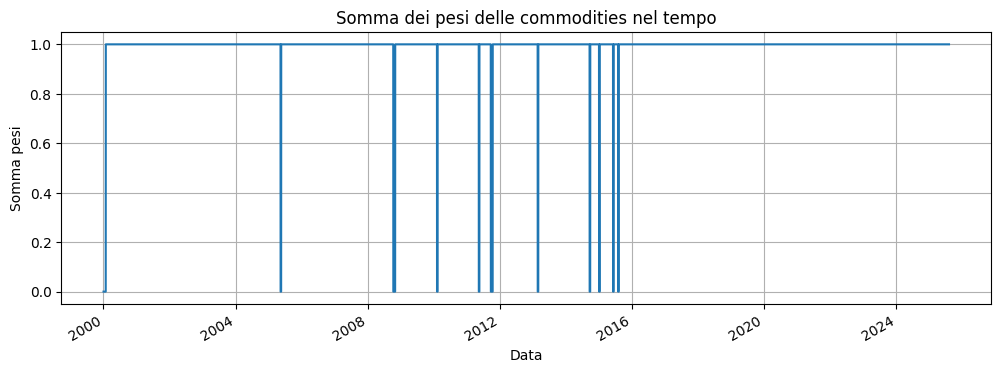

In [8]:
# Controllo della somma dei pesi per ogni data (segnali aggiornati)
somma_pesi = signals_aligned.sum(axis=1)
print('Valore minimo della somma dei pesi:', somma_pesi.min())
print('Valore massimo della somma dei pesi:', somma_pesi.max())
somma_pesi.plot(title='Somma dei pesi delle commodities nel tempo', figsize=(12,4))
plt.xlabel('Data')
plt.ylabel('Somma pesi')
plt.grid(True)
plt.show()

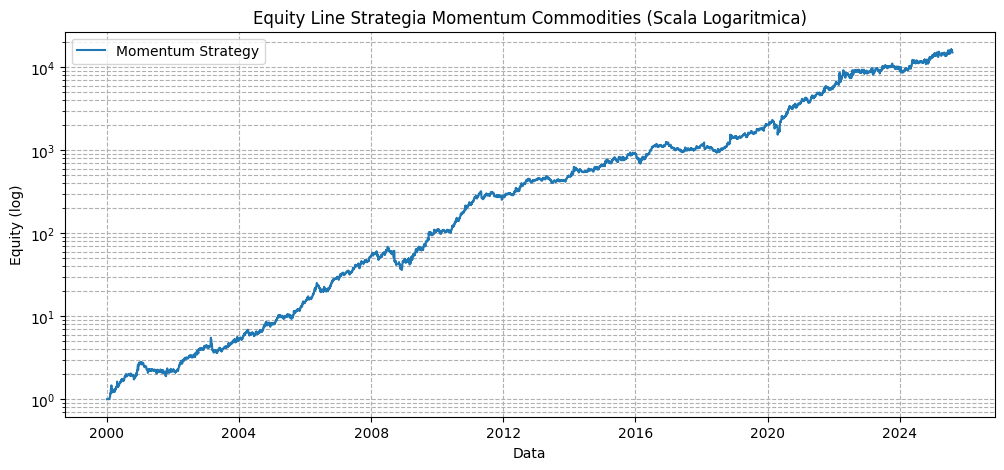

In [9]:
# Equity line in scala logaritmica
plt.figure(figsize=(12,5))
plt.plot(equity, label='Momentum Strategy')
plt.yscale('log')
plt.title('Equity Line Strategia Momentum Commodities (Scala Logaritmica)')
plt.xlabel('Data')
plt.ylabel('Equity (log)')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()